# `OpenCV` 快速入门

## 角点检测

用于检测从(灰度)图像中提取稳定、易于跟踪的特征点（灰度变化剧烈的角点）。

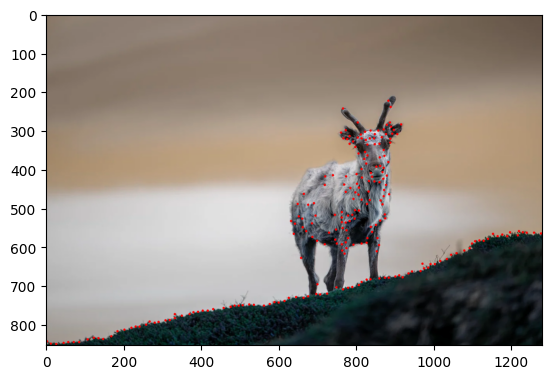

In [30]:
import cv2
import matplotlib.pyplot as plt


image = cv2.imread('../img/sheep.jpg')

if image is None:
    print("错误：无法读取图像 ")
else:
    # 将图片转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 提前图片的角点，并将角点画一个圆点
    corners = cv2.goodFeaturesToTrack(gray, 500, 0.1, 10)
    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(image, (int(x), int(y)), 3, (255,0,0), -1)

    plt.imshow(image)


## 模板匹配（以图搜图）

在一张大图（源图像）中寻找与小图（模板图像）最相似的区域，，输出每个可能位置的匹配程度。

相似度算法包括：

- cv2.TM_CCOEFF：相关系数匹配，值越大越相似
- cv2.TM_CCOEFF_NORMED：归一化相关系数匹配，取值范围[0,1]，1 表示完全匹配
- cv2.TM_SQDIFF：平方差匹配，值越小越相似
- cv2.TM_SQDIFF_NORMED：归一化平方差匹配，取值范围[0,1]，0 表示完全匹配

仅适用于尺度、旋转、光照不变的场景，若目标发生缩放、旋转或光照变化，匹配效果会大幅下降。
对噪声敏感，需提前预处理（如平滑滤波）。

典型应用场景：

- 固定位置的目标检测（如工业流水线上的零件定位）。
- 简单的图像检索（如在截图中查找特定图标）。
- 视频中固定形状目标的跟踪（如监控中跟踪特定标志）。


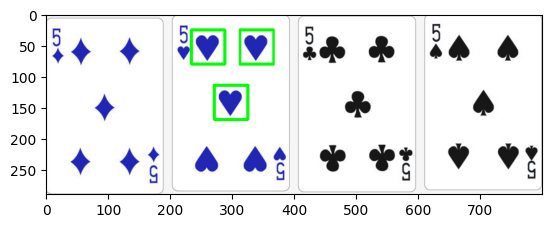

In [31]:
import numpy as np

image = cv2.imread('../img/poker.jpg')
if image is None:
    print("错误：无法读取图像 ")
else:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    template = cv2.imread('../img/heart.png')
    if template is None:
        print("错误：无法读取模板图像 ")
    else:
        template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # 对匹配图形大小是敏感的，要求大小也要一致才能匹配
        match_area = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF_NORMED)
        localtions = np.where(match_area > 0.95)

        w, h = template.shape[:2]
        for p in zip(*localtions[::-1]):
            cv2.rectangle(image, p, (p[0] + w, p[1] + h), (0, 255, 0), 2)

        plt.imshow(image)

## 边缘检测

### `Laplacian` 边缘检测

拉普拉斯（Laplacian）是一种基于二阶导数的边缘检测方法。它通过检测图像中灰度值的快速变化来识别边缘。

局限性：

- 会放大图像噪声，实际应用中通常需要先进行平滑处理（如高斯滤波）；
- 只能检测边缘的存在，无法提供边缘方向信息；
- 对较强的边缘响应可能出现双边缘现象。

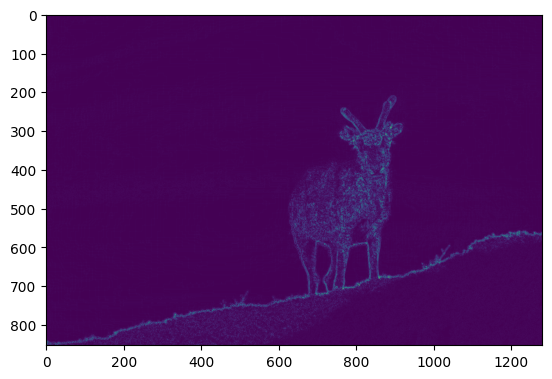

In [39]:
# 读取图像并转为灰度图
img = cv2.imread('../img/sheep.jpg')
if img is None:
    print("错误：无法读取图像 ")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 先高斯滤波去除噪声
    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    # 计算拉普拉斯算子
    laplacian = cv2.Laplacian(blur, cv2.CV_64F)  # 使用64位浮点型避免截断
    laplacian = np.uint8(np.absolute(laplacian))  # 取绝对值并转为8位

    # 显示结果
    plt.imshow(laplacian)

### `Canny` 边缘检测

经典的多阶段边缘检测算法，通过四个步骤实现从图像中提取清晰、连续的边缘：

- 高斯滤波：去噪预处理，平滑图像以减少噪声干扰
- 计算梯度幅值和方向：定位图像中灰度变化剧烈的区域
- 非极大值抑制（NMS）：将宽边缘 “细化” 为单像素宽度，保留局部梯度最大的点
- 双阈值检测与边缘连接：区分强边缘、弱边缘和非边缘，通过阈值筛选并连接边缘。

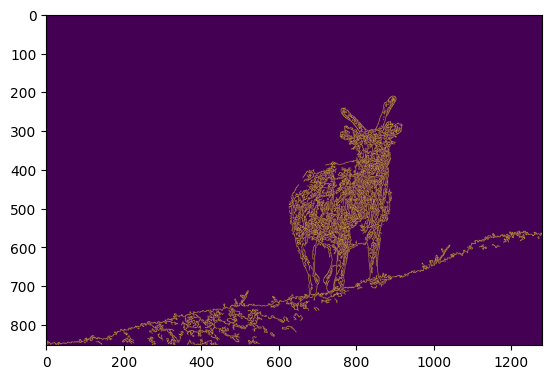

In [42]:
# 读取图像并转为灰度图
img = cv2.imread('../img/sheep.jpg')
if img is None:
    print("加载图片错误")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Canny边缘检测（阈值需根据图像调整）
    edges = cv2.Canny(gray, 50, 150)  # 低阈值50，高阈值150

    plt.imshow(edges)

## 阈值算法

将每个像素的灰度值与预设阈值比较，根据比较结果将像素标记为特定值（如 0 或 255），实现图像的二值化（或多值化）。可将图像分割为前景（目标）和背景两部分。它广泛适用于灰度图像，能快速提取感兴趣区域，是图像分割、目标检测等任务的基础。

阈值策略:

- cv2.THRESH_BINARY：二进制阈值，pixel > thresh → maxval；否则 → 0
- cv2.THRESH_BINARY_INV：反二进制阈值，pixel > thresh → 0；否则 → maxval
- cv2.THRESH_TRUNC：截断阈值，pixel > thresh → thresh；否则 → 保持原值
- cv2.THRESH_TOZERO：阈值到零，pixel > thresh → 保持原值；否则 → 0
- cv2.THRESH_OTSU：大津法，通过计算图像灰度直方图自动确定阈值

其它方式：像素周围的局部区域动态计算阈值，cv2.adaptiveThreshold

使用场景：

- 文档扫描：提取文字（前景）与背景分离，如身份证、试卷扫描后的二值化处理。
- 目标分割：在简单背景下提取目标，例如工业检测中分割零件与传送带。
- 特征提取预处理：为轮廓检测、形状分析等提供二值化图像，减少计算量。
- 医学影像：突出病灶区域，如 X 光片的骨骼与软组织分离。

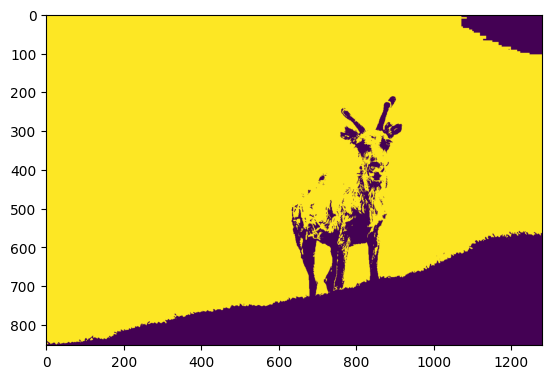

In [55]:
gray = cv2.imread('../img/sheep.jpg', cv2.IMREAD_GRAYSCALE)
if gray is None:
    print('打开图片错误')
else:
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.imshow(binary)
